In [11]:
!pip install sportsdataverse
import sportsdataverse as sdv
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Flatten, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import pandas as pd
import numpy as np

In [12]:
player_stat=sdv.mbb.load_mbb_player_boxscore(seasons=range(2021,2022)).to_pandas()
team_stat=sdv.mbb.load_mbb_team_boxscore(seasons=range(2021,2022)).to_pandas()
features=["field_goals_made","field_goals_attempted",
          'three_point_field_goals_made','three_point_field_goals_attempted',
          'free_throws_made','free_throws_attempted',
          'offensive_rebounds','defensive_rebounds',
          'assists','blocks',
          'steals','turnovers',
          'fouls'
          ]

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


In [13]:
player_stat.sort_values(by="game_date")
team_stat.sort_values(by=['game_date','game_id'],inplace=True)
def flagging_home(x):
    if x =="home":
      return 1
    else:
      return 0
team_stat['home']=team_stat['team_home_away'].apply(flagging_home)
team_stat['team_id']

8464     232
8465     153
8404    2277
8405    2628
8536    2181
        ... 
5        239
2         26
3       2250
0        239
1       2250
Name: team_id, Length: 8566, dtype: int32

In [14]:
# Given team id find 8 most active player in this season based on their time on the ground
active_player_by_teamid={team_id:player_stat[player_stat['team_id']==team_id].groupby(by=['athlete_id'])['minutes'].mean().dropna().sort_values().index[-5:] for team_id in np.unique(player_stat['team_id'])}
# Given game date and athelete id, find average stat of that player in all of the previous game in this season
def season_avg_player(player_stat,game_date,athlete_id,features):
    return player_stat[(player_stat['athlete_id']==athlete_id) & (player_stat['game_date']<game_date)].sort_values(by=["game_date"])[features].mean()
# For every game, using game date and team id to compile a 2D matrix(rows=playerid columns=average stat of all previous game for that player)
empty={}
for idx,row in tqdm(team_stat.iterrows()):
    team_id,game_date,oppo_team_id=row['team_id'],row['game_date'],row['opponent_team_id']
    temp=[]
    # make sure both team has played 5 games before individually
    if team_stat[(team_stat['team_id']==team_id) & (team_stat['game_date']<game_date)].sort_values(by=["game_date"]).shape[0]>4 and team_stat[(team_stat['team_id']==oppo_team_id) & (team_stat['game_date']<game_date)].sort_values(by=["game_date"]).shape[0]>4:
        #Calculate every player stat in that team
        for athlete_id in active_player_by_teamid[team_id]:
            temp.append(season_avg_player(player_stat,game_date,athlete_id,features))
        #Check if any player has nan
        empty[idx]=pd.concat(temp,axis=1).transpose()


8566it [02:21, 60.40it/s]


In [15]:
y=[] # indicate if away team win or lose
x=[] # data
# combine every other row into a 3d materix
for i in range(0,8567,2):
    if i in empty:
        x.append(np.stack([empty[i], empty[i+1]], axis=0))
        y.append(team_stat.loc[i]['team_winner'])
for idx,element in enumerate(x):
      if np.isnan(np.min(x[idx])):
              x.pop(idx)
              y.pop(idx)
y=[1 if i else 0 for i in y]
x=np.array(x)
y=np.array(y)

In [16]:
#Reshape trainig data to put channel last
x = np.moveaxis(x, -3, -1)
x.shape

(2915, 5, 13, 2)

In [7]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Flatten, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def get_model(player_shape):
    # Create Convolutional Network
    conv_model = Sequential(name="Conv")
    conv_model.add(Conv2D(filters=32, kernel_size=(1, 13), input_shape=player_shape,
                         data_format="channels_last",
                         activation="tanh", name="Convolutional"))
    # Flatten the results
    conv_model.add(Flatten(name="Flatten"))

    # Wrap this first part of the network
    X = Input(shape=player_shape, name="PlayerInput")
    conv_encoded = conv_model(X)

    # Create dense network with conv results and team data as inputs
    #dense_input = Input(shape=team_shape)
    #x = concatenate([conv_encoded, dense_input])
    x=conv_encoded
    x = Dense(32, activation="tanh", kernel_regularizer = l2(0.02876), name="Dense64")(x)
    x = Dropout(0.2)(x)
    x = Dense(8, activation="tanh", kernel_regularizer = l2(0.02875), name="Dense16")(x)
    x = Dropout(0.08)(x)

    # Output neuron
    Y = Dense(1, activation='sigmoid', name="Output")(x)

    opt = Adam(lr=0.001)
    nba_model = Model(inputs=X, outputs=Y)
    nba_model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics = ['accuracy']
    )
    print(nba_model.summary())

    return nba_model

model = get_model(
    x[0].shape
)
history = model.fit(x[:2000], y[:2000], epochs=200,
                    validation_data=(x[2000:], y[2000:]))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 PlayerInput (InputLayer)    [(None, 5, 13, 2)]        0         
                                                                 
 Conv (Sequential)           (None, 160)               864       
                                                                 
 Dense64 (Dense)             (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 Dense16 (Dense)             (None, 8)                 264       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 Output (Dense)              (None, 1)                 9     

In [8]:
len(y[2000:])

915

In [9]:
x[0].shape

(5, 13, 2)

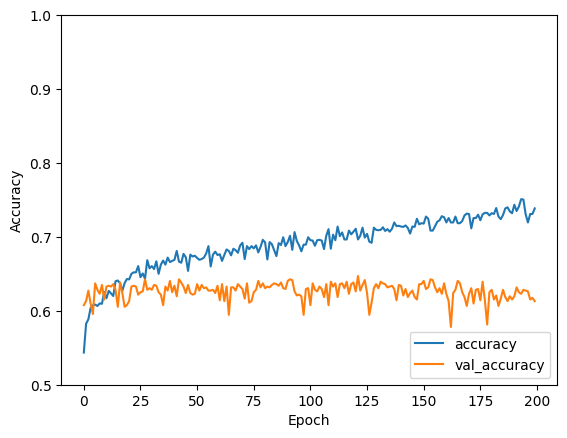

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')